In [198]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from scipy import signal

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR
from datasets import inputs
import seaborn as sns
import pandas as pd
from parula import cm as parula_cm

# Helper functions

In [199]:
def get_M(T, gamma):
    return np.linalg.pinv(np.eye(T.shape[0]) - gamma*T)
    
def normalize(T):
    row_sums = np.sum(T, axis=1)
    unvisited_states = (row_sums == 0)
    T = T/row_sums[:, np.newaxis]
    T[unvisited_states] = 0
    return T

In [200]:
def add_noise(X):
    """ Add Poisson noise with 1/4 scale of max for each row. """
    
    new_X = []
    X = X.copy()
    for x in X:
        x += noise_vec(x)
        new_X.append(x)
    return np.array(new_X)

def hanning_smooth(X):
    """ Smooth each row with Hanning window. """
    
    new_X = []
    X = X.copy()
    win_ratio = 7/60.
    win_size = int(win_ratio*X.shape[1])
    win = signal.windows.hann(win_size)
    win /= np.sum(win)
    for x in X:
        conv_x = signal.convolve(x, win, mode='same')
        new_X.append(conv_x)
    return np.array(new_X)

def remove_insig(X):
    """ Remove any row where peak is < 3 s.d. above mean"""
    
    new_X = []
    X = X.copy()
    for idx, x in enumerate(X):
        if x.max() < np.mean(x) + 2.5*np.std(x):
            continue
        new_X.append(x)
    return np.array(new_X)

def z_score(X):
    """ z-scores each row """
    
    X = X.copy()
    X -= np.mean(X, axis=1)[:, np.newaxis]
    X /= np.std(X, axis=1)[:, np.newaxis]
    return X

# Parameters

In [201]:
visit_length = 5*4
gamma = 0.99

In [202]:
factor = 15
cache_states = list(range(7,16))
cache_states = [c*factor for c in cache_states]

while True:
    dataset = inputs.Sim1DFeederAndCache(
        steps_in_phases=[0,15000,0],
        left_right_stay_prob=[4,1,1], expansion=1,
        num_spatial_states=16*factor,
        visit_length=visit_length,
        feeder_states=[], cache_states=cache_states,
        cache_prob = 0.04
        )
    if np.all([c+dataset.num_spatial_states in dataset.state_inputs for c in cache_states]):
        break        

# Sanity Check Plots

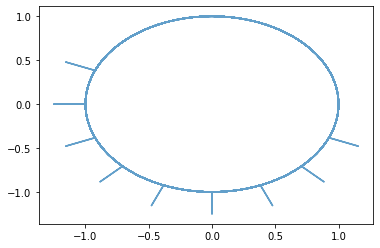

In [203]:
plt.figure();
plt.plot(dataset.xs, dataset.ys, alpha=0.7)
plt.show()

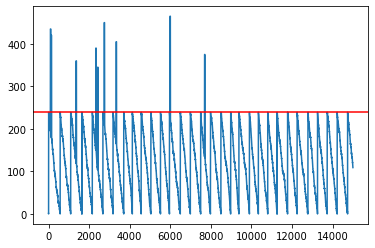

In [204]:
plt.figure();
plt.plot(dataset.state_inputs)
plt.axhline(dataset.num_spatial_states, color='red')
plt.show()

# Run through model

In [205]:
outputs = []
T_counts = np.zeros((dataset.num_expanded_states, dataset.num_expanded_states))
for step in np.arange(1, dataset.num_steps):
    prev_state = dataset.expanded_state_inputs[step-1]
    curr_state = dataset.expanded_state_inputs[step]
    T_counts[prev_state, curr_state] +=1

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_5157/628107314.py:7: RuntimeWarning: invalid value encountered in true_divide
  T = T/row_sums[:, np.newaxis]


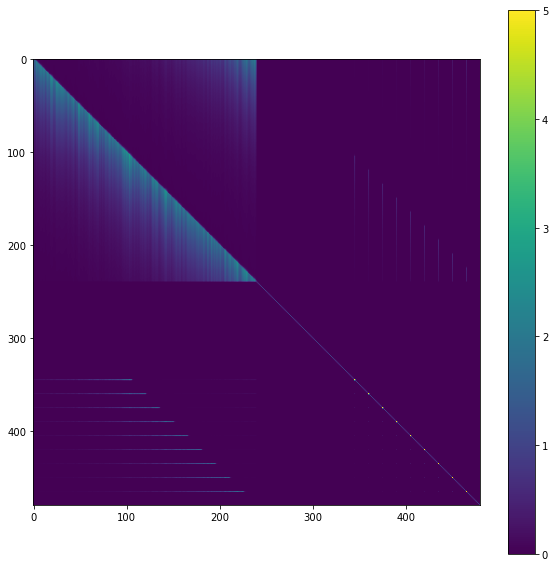

In [221]:
M = get_M(normalize(T_counts), gamma)
plt.figure(figsize=(10,10))
plt.imshow(M, vmax=5)
plt.colorbar()
plt.show()

In [216]:
cache_states

array([345, 360, 375, 390, 405, 420, 435, 450, 465])

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_5157/628107314.py:7: RuntimeWarning: invalid value encountered in true_divide
  T = T/row_sums[:, np.newaxis]


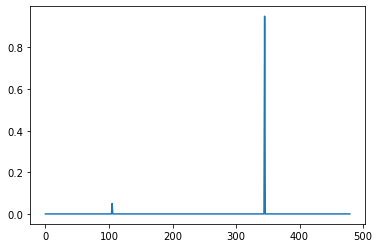

In [217]:
norm_T = normalize(T_counts)
plt.figure()
plt.plot(norm_T[345])
plt.show()

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_5157/628107314.py:7: RuntimeWarning: invalid value encountered in true_divide
  T = T/row_sums[:, np.newaxis]


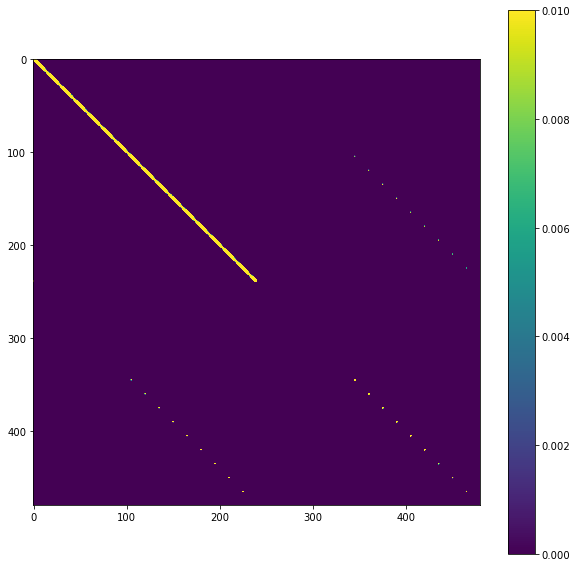

In [220]:
plt.figure(figsize=(10,10))
plt.imshow(normalize(T_counts), vmax=0.01)
plt.colorbar()
plt.show()

# Plot by dist

In [206]:
from scipy.stats import pearsonr

In [207]:
M = get_M(normalize(T_counts), gamma)

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_5157/628107314.py:7: RuntimeWarning: invalid value encountered in true_divide
  T = T/row_sums[:, np.newaxis]


In [208]:
cache_locs = np.array(dataset.cache_states)
cache_states = np.array(dataset.cache_states) + dataset.num_spatial_states

In [209]:
def noise_vec(arr):
    #return np.random.normal(0., 1., size=arr.size)
    #return np.random.poisson(0.5, size=arr.size)
    return np.random.poisson(np.percentile(arr, 50)/3., size=arr.size)

In [210]:
def get_similarities(indices):
    similarities = []
    for dist in range(len(indices)):
        arr1 = M[indices[0]].copy()
        arr2 = M[indices[dist]].copy()
        
        arr1 += noise_vec(arr1)
        arr2 += noise_vec(arr1)
        
        cc = pearsonr(arr1, arr2)[0]
        similarities.append(cc)
    return similarities

iters = 500
similarities = []
dists = []
events = []
for _ in range(iters):
    sim = get_similarities(cache_locs)
    similarities.extend(sim)
    dists.extend(list(range(len(sim))))
    events.extend(['Spatial']*len(sim))
    similarities.extend(sim[1:])
    dists.extend(list(range(-1, -len(sim), -1)))
    events.extend(['Spatial'] * (len(sim)-1))
    
for _ in range(iters):
    sim = get_similarities(cache_states)
    similarities.extend(sim)
    dists.extend(list(range(len(sim))))
    events.extend(['Cache']*len(sim))
    similarities.extend(sim[1:])
    dists.extend(list(range(-1, -len(sim), -1)))
    events.extend(['Cache'] * (len(sim)-1))

In [211]:
df = pd.DataFrame({
    'Similarity': similarities, 'Distance': dists,
    'Event': events
    })

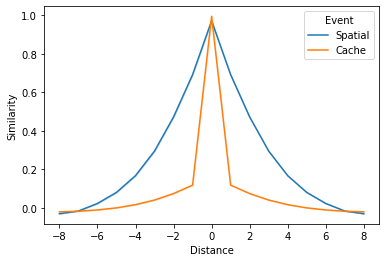

In [212]:
plt.figure()
sns.lineplot(x='Distance', y='Similarity', hue='Event', data=df)
plt.savefig('Similarity.png', dpi=300)
plt.show()

In [192]:
dists = np.array(dists)
events = np.array(events)
similarities = np.array(similarities)

In [193]:
spatial_x = np.arange(-8, 9)
spatial_y = [np.mean(
    similarities[np.logical_and(dists==x, events=='Spatial')]
    ) for x in spatial_x
    ]

cache_x = np.arange(-8, 9)
cache_y = [np.mean(
    similarities[np.logical_and(dists==x, events=='Cache')]
    ) for x in spatial_x
    ]

In [194]:
from scipy.optimize import curve_fit

# Define the Gaussian function for curve fitting
def gauss(x, A, B):
    y = A*np.exp(-1*B*x**2)
    return y
parameters, covariance = curve_fit(gauss, spatial_x, spatial_y)

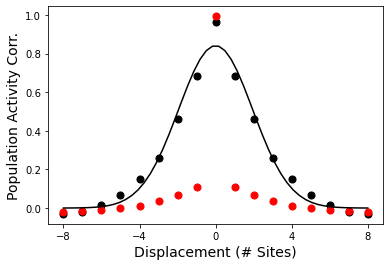

In [195]:
plt.figure()
spatial_fit_x = np.linspace(-8, 8, 50, endpoint=True)
spatial_fit = gauss(spatial_fit_x, parameters[0], parameters[1])
plt.scatter(spatial_x, spatial_y, label='Spatial', color='black', s=50)
plt.plot(spatial_fit_x, spatial_fit, label='Spatial', color='black')
plt.scatter(cache_x, cache_y, label='Cache', color='red', s=50)
plt.ylabel('Population Activity Corr.', fontsize=14)
plt.xlabel('Displacement (# Sites)', fontsize=14)
plt.xticks([-8, -4, 0, 4, 8])
plt.savefig('cache_retrieve.png', dpi=300)
plt.show()

In [196]:
from scipy.io import savemat

In [197]:
savemat('cache_retrieval_corr.mat', {
    'spatial_x': spatial_x,
    'spatial_y': spatial_y,
    'cache_x': cache_x,
    'cache_y': cache_y,
    'spatial_fit_x': spatial_fit_x,
    'spatial_fit_y': spatial_fit,
    })

# Make pileup heat map

In [176]:
def get_popln_plot(cache_loc, cache_state):
    T_counts = np.zeros((dataset.num_expanded_states, dataset.num_expanded_states))
    start_idx = np.argwhere(dataset.expanded_state_inputs==cache_state)[0,0]
    for step in np.arange(start_idx, dataset.num_steps):
        prev_state = dataset.expanded_state_inputs[step-1]
        curr_state = dataset.expanded_state_inputs[step]
        T_counts[prev_state, curr_state] +=1
        
    M = get_M(normalize(T_counts), gamma)
    popln_activity = M.T
    
    # Alias into space
    popln_activity = popln_activity[:, :dataset.num_spatial_states]\
        + popln_activity[:, dataset.num_spatial_states:]
    
    # Drop unused non-spatial rows
    keep_idxs = [
        s for s in range(dataset.num_states) if\
        (s in cache_states) or (s < dataset.num_spatial_states)
        ]
    popln_activity = popln_activity[keep_idxs]
    
    # Center around cache_loc
    keep_idxs = np.mod(keep_idxs, dataset.num_spatial_states)
    keep_idxs -= cache_loc
    popln_activity = popln_activity[np.argsort(keep_idxs)]

    return popln_activity

In [177]:
popln_activity = []
relative_idx = []
for cache_loc, cache_state in zip(cache_locs, cache_states):
    _popln_activity = get_popln_plot(cache_loc, cache_state)
    _popln_activity = add_noise(_popln_activity)
    _popln_activity = hanning_smooth(_popln_activity)
    _popln_activity = remove_insig(_popln_activity)
    _popln_activity = z_score(_popln_activity)
    popln_activity.append(_popln_activity)
popln_activity = np.vstack(popln_activity)

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_16834/628107314.py:7: RuntimeWarning: invalid value encountered in true_divide
  T = T/row_sums[:, np.newaxis]


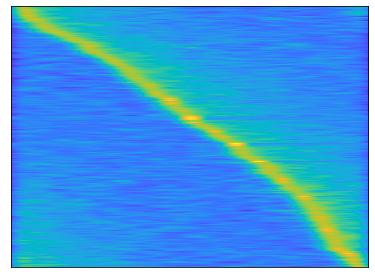

In [191]:
plt.figure(figsize=(6.4, 4.8))
rand_sample = np.random.choice(popln_activity.shape[0], size=450)
samp_popln_activity = popln_activity[rand_sample]
sort_idxs = np.argsort(np.argmax(samp_popln_activity, axis=1))
samp_popln_activity = samp_popln_activity[sort_idxs]
plt.imshow(samp_popln_activity, cmap=parula_cm, aspect='auto')
plt.xticks([]); plt.yticks([])
plt.savefig("feeder_control.png", dpi=300)
plt.show()

In [193]:
savemat('activity_aligned_to_cache.mat',{'data':samp_popln_activity}) # (neurons, location)